Alejandro Burgueño Díaz. 22/08/2021

# DETECCIÓN DE FRAUDE

In [60]:
import dask.dataframe as dd
import pandas as pd
import seaborn as sb 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# EMPLEANDO DASK PARA LEER Y MUESTREAR DATOS

In [55]:
dsk_df = dd.read_csv('credit_card_transactions-ibm_v2.csv')

In [14]:
# Se extraen sólo las filas donde el fraude es sí 
pd_fraud = dsk_df[(dsk_df['Is Fraud?'] == 'Yes')]
pd_fraud = pd_fraud.compute()

# Se extraen sólo las filas donde el fraude es no y se reduce el tamaño 
# La proporción de reducción es distinta, dado que hay muchos menos casos de fraude que de no fraude
pd_no_fraud = dsk_df[(dsk_df['Is Fraud?'] == 'No')]
pd_no_fraud = pd_no_fraud.sample(frac=0.005, random_state=1)
pd_no_fraud = pd_no_fraud.compute()

# Se genera un dataframe pandas y se guarda el csv
data = pd_fraud.append(pd_no_fraud)
data.to_csv('DownsampleData.csv', index=False)

# PREPROCESADO DE DATOS

In [41]:
data = pd.read_csv('DownsampleData.csv')

In [43]:
# Amount:
# El caracter del dólar es innecesario, se debe eliminar y pasar los datos de tipo object a float.
data['Amount'] = data['Amount'].str.replace(r'$', '')

# Time:
# Se opta por pasar a numérico. Eliminando los minutos se simplifica la variable en 24 clases.
data['Time'] = data['Time'].str[:2]

# Use Chip:
# Como hay 3 únicas clases en el dataset depurado (aunque en Kaggle se aprecia el subconjunto "others") se codifican.
data['Use Chip'] = data['Use Chip'].replace({"Swipe Transaction": 0, "Chip Transaction": 1, "Online Transaction": 2})

# Merchant City:
# También se binariza la columna, sustituyendo ONLINE por 1 y el resto por 0
data['Merchant City'].loc[data['Merchant City'] != 'ONLINE'] = 0
data['Merchant City'].loc[data['Merchant City'] == 'ONLINE'] = 1

# Merchant State:
# Se utiliza un label encoder para codificar los estados
data['Merchant State'].loc[data['Merchant State'].isnull()] = 'No State'   # Se sustituyen los Nan por un string
encoder = LabelEncoder()
encoder.fit(data['Merchant State'])
data['Merchant State'] = encoder.transform(data['Merchant State'])

# Zip:
# Se sustituyen los valores NaN por 0.
data['Zip'].loc[data['Zip'].isnull()] = 0  

# Errors?:
# Para simplificar el dataset se considerarán todos los NaN como 0 (no hay errores) y todos los demás errores como 1.
data['Errors?'].loc[~data['Errors?'].isnull()] = 1  # not nan
data['Errors?'].loc[data['Errors?'].isnull()] = 0   # nan

# Is Fraud?:
# También se binariza la columna, sustituyendo No por 0 y Yes por 1
data['Is Fraud?'].loc[data['Is Fraud?'] == 'No'] = 0
data['Is Fraud?'].loc[data['Is Fraud?'] == 'Yes'] = 1

# Se convierten los datos a floats
data = data .astype(float)

# Se guarda el dataset
data.to_csv('PreprocessedData.csv', index=False)

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [56]:
data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0.0,0.0,2015.0,11.0,15.0,12.0,287.13,2.0,-8.194608e+18,1.0,80.0,0.0,3001.0,0.0,1.0
1,0.0,0.0,2015.0,11.0,15.0,13.0,2.41,2.0,-7.759074e+18,1.0,80.0,0.0,5651.0,0.0,1.0
2,0.0,0.0,2015.0,11.0,16.0,9.0,50.81,2.0,-5.513321e+17,1.0,80.0,0.0,4411.0,0.0,1.0
3,0.0,0.0,2015.0,11.0,16.0,9.0,248.36,2.0,4.872341e+18,1.0,80.0,0.0,5732.0,0.0,1.0
4,0.0,0.0,2015.0,11.0,16.0,11.0,473.00,2.0,-8.566952e+18,1.0,80.0,0.0,3640.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151536,1997.0,1.0,2011.0,11.0,26.0,11.0,3.84,0.0,1.799190e+18,0.0,40.0,60616.0,5499.0,0.0,0.0
151537,1955.0,1.0,2014.0,3.0,29.0,8.0,5.19,0.0,4.722913e+18,0.0,70.0,68164.0,5411.0,0.0,0.0
151538,1986.0,0.0,2014.0,2.0,20.0,11.0,10.60,0.0,9.703280e+16,0.0,103.0,37920.0,5411.0,0.0,0.0
151539,1980.0,1.0,2018.0,2.0,21.0,8.0,2.58,0.0,-1.288082e+18,0.0,59.0,49720.0,5499.0,0.0,0.0


# ANÁLISIS DE DATOS SOBRE EL DATASET PREPROCESADO

In [57]:
data = pd.read_csv('PreprocessedData.csv')

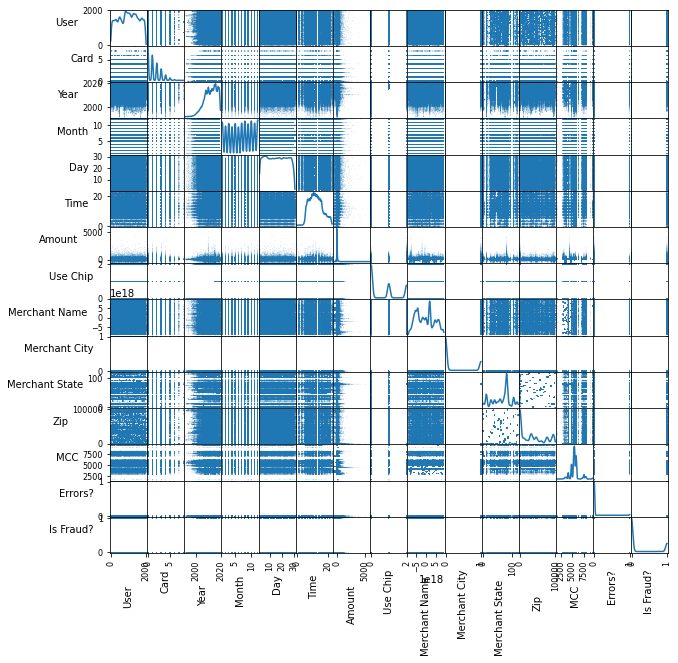

In [58]:
# Matriz de dispersión (scatter) y pares de variables
scatter_matrix = pd.plotting.scatter_matrix(
    data,
    figsize  = [10, 10],
    marker   = ".",
    s        = 1,
    diagonal = "kde"
)

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0, ha='right') 
    
plt.savefig("Matriz_de_dispersión.jpg")

OBSERVACIONES: Son significativas las variables con largas colas, reflejando cierto desbalance de datos.  
* Años (Year) - Antes del 2004 habían pocas transferencias, año a partir del cual empieza a subir la tendencia y al canza su punto álgido en torno al 2012.
* Horas (Time) - La mayoría de las transferencias se realizan durante el día.
* Cantidad (Amount) - Aunque pocas, hay transferencias de valores muy elevados, alejadas de la tendencia.

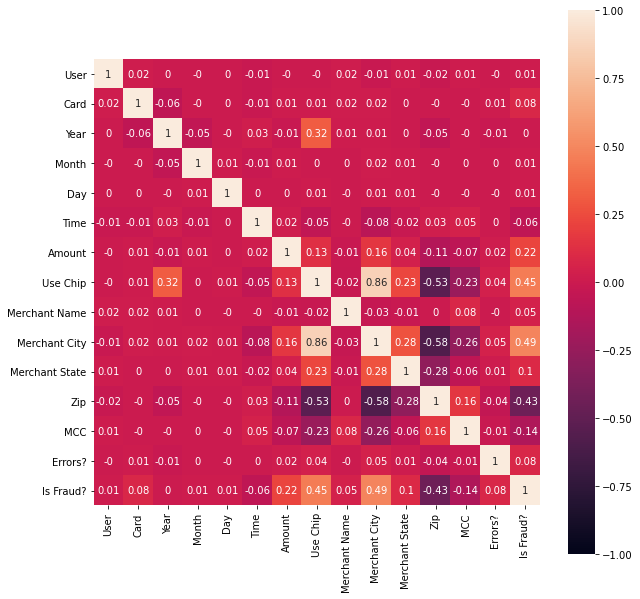

In [61]:
# Matriz de correlación
corrMatrix = data.corr()

plt.rcParams['figure.figsize'] = 10, 10
data_matrix = np.round(corrMatrix, 2)
sb.heatmap(data_matrix, annot = True, vmin=-1, vmax=1, square=True)

plt.savefig('Matriz_de_correlación.pdf')

OBSERVACIONES: La mayoría de las variables presentan poca o escasa correlación.
* El uso de tarjetas (chip) está relacionado con el año, quizá debido a la fecha de aparición de las mismas o mayor tendencia en su uso.
* 
* El uso de tarjetas presenta una correlación relevante con los casos de fraude, así como Merchant City

# COMPARACIÓN DE PARES DE VARIABLES

Este tipo de análisis resulta de utilidad para visualizar situaciones en que NUNCA se han dado anomalías. 
Dicha comparación anticipa los resultados de las reglas de inferencia.

In [62]:
data = pd.read_csv('PreprocessedData.csv')

data_in = data.loc[data['Is Fraud?'] == 0.0]
data_out = data.loc[data['Is Fraud?'] == 1.0]

In [63]:
def compare (x,y):
    plt.scatter(data_in[x], data_in[y] )
    plt.scatter(data_out[x], data_out[y], linewidths=5, c='red' )

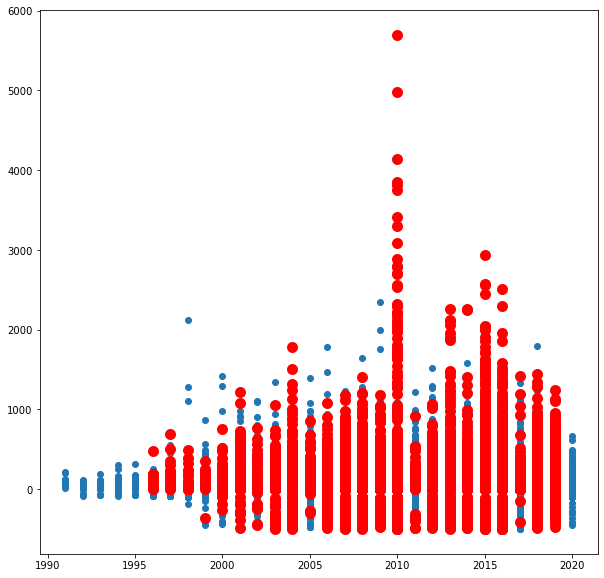

In [64]:
compare('Year','Amount')

OBSERVACIONES: 
* Antes del año 1995 no se aprecian transferencias fraudulentas. En el resto del conjunto de datos se aprecia fraude bajo cualquier cantidad económica.
* Se sobreentiende que el dataset no contiene datos actualizados, al no presentar movimientos fraudulentos en el 2020.
* Los movimientos de mayor importe se realizan en el 2010, posiblemente relacionado con la crisis económica.
* Cabe destacar que en los años 1998, 2000, 2005, 2006, 2007, 2011 y 2012 los movimientos de mayor importe nunca son fraudulentos o no eran detectados.

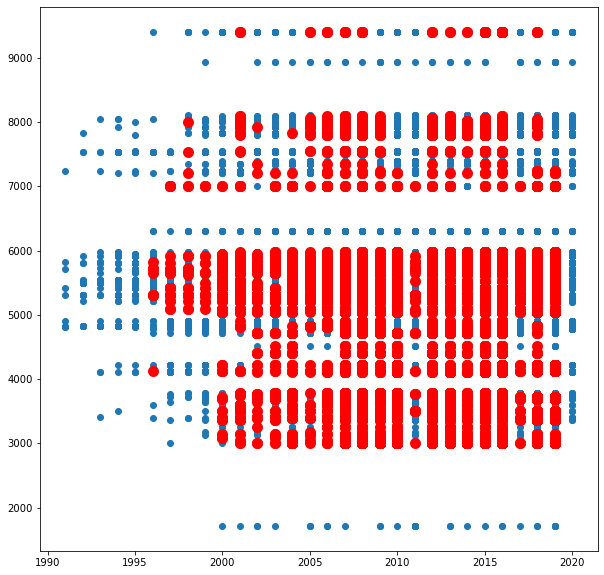

In [65]:
compare('Year','MCC')

OBSERVACIONES: Hay determinadas categorías de códigos mercantiles (MCC) que nunca son fraudulentas, muy aisladas del resto.

# DESARROLLO DEL MODELO DE MACHINE LEARNING

A menudo son útiles métodos de Aprendizaje No Supervisado para resolver problemas de detección de fraude.  
Esta solución es interesante cuando no existen ejemplos en que el fraude ha sido detectado, es decir, cuando la única manera de predecir el fraude es a través de aprendizaje no supervisado o de datos anómalos en función de la estructura de los datos, la agrupación, la desviación estándar, la exclusión de los cuartiles o el desbalance de los datos.  
En tales casos se emplean métodos como Isolation Forest o LOF (Local Outlier Factor), sin embargo, como en este dataset se dispone de casos etiquetados como fraudulentos se realizará un estudio sobre modelos de Aprendizaje Supervisado.

In [49]:
data = pd.read_csv('PreprocessedData.csv')
data['Is Fraud?'].value_counts()

0.0    121784
1.0     29757
Name: Is Fraud?, dtype: int64

In [83]:
# Se cargan las librerías de Machine Learning
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from dtreeviz.trees import *
from IPython.core.display import display, HTML

In [51]:
# Se aislan las variables de entrada 'X' de la variable predictora 'y', la que queremos hallar
X = data.drop('Is Fraud?', axis=1)     # Variables 'X', todas menos la etiqueta 'Is Fraud', la variable predictora
y = data['Is Fraud?']                  # Variable 'y', la etiqueta binaria 'Is Fraud'

# Se convierten las variables a numpy para posteriormente poder aplicar reshape y adaptar su dimensión
X = np.nan_to_num(X)
y = np.nan_to_num(y)

# Finalmente, para evitar overfitting se dividen el conjunto de datos en conjunto de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test = X_test.reshape(-X_test.shape[0],X_test.shape[1])    #Reshape de X_test para poder introducirlo

In [52]:
def metricas ():
    print("-----------------------------------------------------")
    print('Métricas de error:')
    print('MAE', metrics.mean_absolute_error(y, y_pred))  
    print('MSE', metrics.mean_squared_error(y, y_pred))  
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_pred)))
    print("-----------------------------------------------------")
    print('Matriz de Confusión:')
    print(metrics.confusion_matrix(y, y_pred))
    print("-----------------------------------------------------")
    print('Report:')
    print(metrics.classification_report(y, y_pred))

In [53]:
print("RANDOM FOREST")
clf = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

RANDOM FOREST
-----------------------------------------------------
Métricas de error:
MAE 0.00979272936037112
MSE 0.00979272936037112
RMSE: 0.09895822027689827
-----------------------------------------------------
Matriz de Confusión:
[[121572    212]
 [  1272  28485]]
-----------------------------------------------------
Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    121784
         1.0       0.99      0.96      0.97     29757

    accuracy                           0.99    151541
   macro avg       0.99      0.98      0.98    151541
weighted avg       0.99      0.99      0.99    151541



In [54]:
print("K NEAREST NEIGHBORS")
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

K NEAREST NEIGHBORS
-----------------------------------------------------
Métricas de error:
MAE 0.036683141855999364
MSE 0.036683141855999364
RMSE: 0.19152843615505077
-----------------------------------------------------
Matriz de Confusión:
[[120133   1651]
 [  3908  25849]]
-----------------------------------------------------
Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    121784
         1.0       0.94      0.87      0.90     29757

    accuracy                           0.96    151541
   macro avg       0.95      0.93      0.94    151541
weighted avg       0.96      0.96      0.96    151541



In [82]:
print("ADABOOST")
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

ADABOOST
-----------------------------------------------------
Métricas de error:
MAE 0.060445687965633065
MSE 0.060445687965633065
RMSE: 0.24585704782583123
-----------------------------------------------------
Matriz de Confusión:
[[118619   3165]
 [  5995  23762]]
-----------------------------------------------------
Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96    121784
         1.0       0.88      0.80      0.84     29757

    accuracy                           0.94    151541
   macro avg       0.92      0.89      0.90    151541
weighted avg       0.94      0.94      0.94    151541



In [72]:
print("SVM RBF KERNEL")
clf = svm.SVC(kernel="rbf")
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

SVM RBF KERNEL
-----------------------------------------------------
Métricas de error:
MAE 0.19636270052329072
MSE 0.19636270052329072
RMSE: 0.4431283115794913
-----------------------------------------------------
Matriz de Confusión:
[[121784      0]
 [ 29757      0]]
-----------------------------------------------------
Report:


C:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    121784
         1.0       0.00      0.00      0.00     29757

    accuracy                           0.80    151541
   macro avg       0.40      0.50      0.45    151541
weighted avg       0.65      0.80      0.72    151541



In [76]:
print("QUADRATIC DISCRIMINANT ANALYSIS")
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

QUADRATIC DISCRIMINANT ANALYSIS


C:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


-----------------------------------------------------
Métricas de error:
MAE 0.19636270052329072
MSE 0.19636270052329072
RMSE: 0.4431283115794913
-----------------------------------------------------
Matriz de Confusión:
[[121784      0]
 [ 29757      0]]
-----------------------------------------------------
Report:


C:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    121784
         1.0       0.00      0.00      0.00     29757

    accuracy                           0.80    151541
   macro avg       0.40      0.50      0.45    151541
weighted avg       0.65      0.80      0.72    151541



In [77]:
print("GAUSSIAN NAIVE BAYES")
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X)

metricas()

GAUSSIAN NAIVE BAYES
-----------------------------------------------------
Métricas de error:
MAE 0.19636270052329072
MSE 0.19636270052329072
RMSE: 0.4431283115794913
-----------------------------------------------------
Matriz de Confusión:
[[121784      0]
 [ 29757      0]]
-----------------------------------------------------
Report:


C:\Users\Alejandro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    121784
         1.0       0.00      0.00      0.00     29757

    accuracy                           0.80    151541
   macro avg       0.40      0.50      0.45    151541
weighted avg       0.65      0.80      0.72    151541



OBSERVACIONES: 
* El modelo que presenta un mejor rendimiento es Random Forest, con un accuracy de 0.99 y las métricas de error más bajas. K nearest neighbours y Adaboost también resultan en un modelos con pocos FP y FN, pero sigue clasificando mejor Random Forest.  
* Los modelos de SVM, Gaussian NB y QDiscriminant Analysis no son capaces de computar los valores ruidosos que presenta este modelo y la baja proporción de casos de fraude, clasificando todos los datos como "no fraude".  
* Dado el buen resultado de Random Forest y Ada Boost se deduce que dada la naturaleza del problema éste puede resolverse bien a través de métodos de ensemble. Por ello, podría mejorarse el rendimiento a través de sistemas de Votación o agrupación de Random Forest.  
* Cabe destacar que para esta prueba no se han realizado métodos de búsqueda de hiperparámetros que podrían haber mejorado el rendimiento de los modelos (como búsqueda por rejilla o búsqueda aleatoria).

# REGLAS DE INFERENCIA

Puede resultar útil extraer reglas de inferencia de modelos caja blanca, como los árboles de decisión o la regresión lineal. En este caso, aprovechando que Random Forest es el modelo que resulta más efectivo entre los testados, se estudian las reglas de inferencia de uno de los árboles que lo componen.

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=8)
clf.fit(X, y)

feature_names = list(data.drop('Is Fraud?', axis=1).columns)

viz = dtreeviz(clf.estimators_[0], 
               X,
               y,
               target_name='Is Fraud?',
               feature_names = feature_names, 
               class_names=["Not Fraud", "Fraud"],
               scale=2,
               histtype= 'barstacked')  
viz

<img src="ReglaInferencia.JPG">

OBSERVACIONES: 
* La variable de usar chip resulta muy relevante a la hora de considerar un posible fraude, siendo la clase 2 (se recuerda que viene de la codificación "Online Transaction") la que más tendencia al fraude genera.
* La cantidad de la transacción también supone un gran índice de fraude, sobre todo en casos donde la transacción ha sido online y se abonan grandes sumas de dinero.
* Incluso en el caso en que se usa chip a través de otras modalidades con menos tendencia al fraude ("swipe transaction" o "chip transaction"), dicha tendencia también aumenta, aunque en menor medida, cuando la cantidad consiste en grandes sumas de dinero.